zyw w 2
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

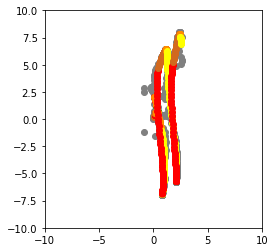

In [2]:
from Plot import *
person = 'zyw'
ch = 'w'
rep = 2
path = np.load('study2/{person}/{ch}_{rep}.npy'.format(person=person,ch=ch,rep=rep))
plotDirections6(path,person, LETTER.index(ch),rep)

In [284]:
ANGLE_THRESHOLD = np.pi / 4
ANGLE_THRESHOLD_2 = np.pi / 10
MERGE_THRESHOLD = 15
MERGE_DIST_THRESHOLD = 1
HV_THRESHOLD = 0.6
HV_AVG_THRESHOLD = 0.5

def angleDiff(u, v):
    ang1 = np.arctan2(u[1], u[0])
    ang2 = np.arctan2(v[1], v[0])
    return 2 * np.pi - abs(ang1 -
                            ang2) if abs(ang1 -
                                        ang2) >= np.pi else abs(ang1 -
                                                                ang2)

# smooth the path
x, y, d = getAveragePath(path,False)
x = gaussian_filter1d(x, sigma=8)
y = gaussian_filter1d(y, sigma=8)
d = gaussian_filter1d(d, sigma=8)

# collecting extrema points of pressure
d=np.array(d)
clamped_d = (d - np.min(d)) / (np.max(d) - np.min(d))
pressure_persistence_pairs = sorted(
    [t for t in RunPersistence(clamped_d) if t[1] > 0.05],
    key=lambda x: x[0])
pre_collected_corners=[int(ppp[0]) for ppp in pressure_persistence_pairs]
if pre_collected_corners[0] - 0 > MERGE_THRESHOLD:
    pre_collected_corners.insert(0,0)
if len(x) - 1 - pre_collected_corners[-1] > MERGE_THRESHOLD:
    pre_collected_corners.append(len(x) - 1)

# filter the turning points that seperates angles
debug_dir = []
debug_dir.append(pre_collected_corners[0])
for u,v in list(zip(pre_collected_corners[:-1],pre_collected_corners[1:])):
    i = u+1
    while i < v:
        cur_v = (x[i] - x[i - 1], y[i] - y[i - 1])
        j = i
        while j < v and angleDiff(
            (x[j] - x[j - 1], y[j] - y[j - 1]),
                cur_v) < ANGLE_THRESHOLD and angleDiff(
                    (x[j] - x[j - 1], y[j] - y[j - 1]),
                    (x[i] - x[i - 1], y[i] - y[i - 1])) < ANGLE_THRESHOLD:
            cur_v = (x[j] - x[i - 1], y[j] - y[i - 1])
            j += 1
        debug_dir.append(j-1)
        i = j

# merge redundant points caused by overreact
real_debug_dir=[]
for dd in debug_dir:
    if len(real_debug_dir)<=1:
        real_debug_dir.append(dd)
        continue
    if angleDiff((x[real_debug_dir[-1]]-x[real_debug_dir[-2]],y[real_debug_dir[-1]]-y[real_debug_dir[-2]]),(x[dd]-x[real_debug_dir[-1]],y[dd]-y[real_debug_dir[-1]])) <= ANGLE_THRESHOLD_2:
        real_debug_dir[-1]=dd
    else:
        real_debug_dir.append(dd)
debug_dir=real_debug_dir

# i = 1
# while i < len(x):
#     cur_v = (x[i] - x[i - 1], y[i] - y[i - 1])
#     j = i
#     while j < len(x) and angleDiff(
#         (x[j] - x[j - 1], y[j] - y[j - 1]),
#             cur_v) < ANGLE_THRESHOLD and angleDiff(
#                 (x[j] - x[j - 1], y[j] - y[j - 1]),
#                 (x[i] - x[i - 1], y[i] - y[i - 1])) < ANGLE_THRESHOLD:
#         cur_v = (x[j] - x[i - 1], y[j] - y[i - 1])
#         j += 1
#     debug_dir.append(j-1)
#     i = j

# merge points that are enough close to each other
i = 0
simplified_dir = []
while i < len(debug_dir):
    t = []
    lat = debug_dir[i]
    while i < len(debug_dir) and (debug_dir[i] - lat < MERGE_THRESHOLD or (x[debug_dir[i]]-x[lat])**2+(y[debug_dir[i]]-y[lat])**2<MERGE_DIST_THRESHOLD):
        t.append(debug_dir[i])
        lat = debug_dir[i]
        i += 1
    simplified_dir.append(int(np.mean(t)))

# calculate the average of x/y offsets
x_avg, y_avg = 0, 0
for u, v in list(zip(simplified_dir[:-1], simplified_dir[1:])):
    if abs(x[v] - x[u]) > abs(y[v] - y[u]):
        x_avg += abs(x[v] - x[u])
    else:
        y_avg += abs(y[v] - y[u])
x_avg = x_avg / (len(simplified_dir) - 1)
y_avg = y_avg / (len(simplified_dir) - 1)

# filter the turning points that are far enough to each other
filtered_dir = []
for sd in simplified_dir:
    if len(filtered_dir) <= 0:
        filtered_dir.append(sd)
        continue
    x_off = abs(x[sd] - x[filtered_dir[-1]])
    y_off = abs(y[sd] - y[filtered_dir[-1]])
    if x_off > y_off and x_off > x_avg * HV_AVG_THRESHOLD and x_off > HV_THRESHOLD:
        filtered_dir.append(sd)
    elif y_off > x_off and y_off > y_avg * HV_AVG_THRESHOLD and y_off > HV_THRESHOLD:
        filtered_dir.append(sd)
    elif x_off == y_off and (
        (x_off > x_avg * HV_AVG_THRESHOLD and x_off > HV_THRESHOLD) or
        (y_off > y_avg * HV_AVG_THRESHOLD and y_off > HV_THRESHOLD)):
        filtered_dir.append(sd)

[0, 25, 44, 76, 96]

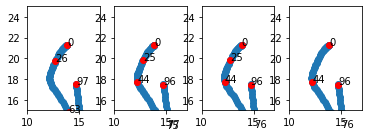

In [285]:
%matplotlib inline
fig, axes=plt.subplots(1,4)
for i, l in enumerate([pre_collected_corners,debug_dir,simplified_dir,filtered_dir]):
    axes[i].axis("scaled")
    axes[i].set_xlim(10, 17)
    axes[i].set_ylim(15, 25)
    axes[i].scatter(x,y)
    for f_d in l:
        axes[i].scatter([x[f_d]],[y[f_d]],c='red')
        axes[i].text(x[f_d],y[f_d],str(f_d))
simplified_dir

In [138]:
i=0
j=30
print(x[i]-x[j])
print(y[i]-y[j])


2.1891824257336694
2.3254409128634848


In [6]:
from Plot import *

def angleDist(ang1, ang2):
    return 1 - (np.dot(ang1, ang2) / np.linalg.norm(ang1) /
                np.linalg.norm(ang2))

usr_angles = []
std_angles = []
for dir in os.listdir(BASE_DIR):
    if not 'letter_' in dir or not os.path.isdir(
            os.path.join(BASE_DIR, dir)):
        continue
    for t_l_i, t_l in enumerate(LETTER):
        for rep in range(5):
            try:
                path = np.load(
                    os.path.join(BASE_DIR, dir, "%s_%d.npy" % (t_l, rep)))

                x, y, d = getAveragePath(path, align_to_first=False)
                corners = getCorners(path)
                directions_index, redundant_8directions, weights = get8Directions(
                    path)
                identified_directions_index = []

                path_directions = [
                    np.array([
                        np.cos(EIGHT_DIRECTIONS[i]),
                        np.sin(EIGHT_DIRECTIONS[i])
                    ]) for i in redundant_8directions
                ]
                std_directions = [
                    np.array([
                        np.cos(EIGHT_DIRECTIONS[i]),
                        np.sin(EIGHT_DIRECTIONS[i])
                    ]) for i in DIRECTION_PATTERN8[t_l]
                ]
                paths = dtw_ndim.warping_path(path_directions,
                                                std_directions)
                idx = 0
                while idx < len(paths):
                    match_list = []
                    current_std_idx = paths[idx][1]
                    while idx < len(
                            paths) and paths[idx][1] == current_std_idx:
                        match_list.append(paths[idx][0])
                        idx += 1
                    identified_directions_index.append(
                        directions_index[match_list[np.argmin([
                            angleDist(path_directions[m_l],
                                        std_directions[current_std_idx])
                            for m_l in match_list
                        ])]])

                # plt.axis("scaled")
                # plt.xlim(10, 17)
                # plt.ylim(15, 25)
                # plt.scatter(x, y, c='blue')
                # for _, corner in enumerate(corners):
                #     plt.scatter([x[corner]], [y[corner]], c='red')
                #     plt.text(x[corner], y[corner], str(_))
                # for iu, iv in identified_directions_index:
                #     plt.plot([x[iu], x[iv]], [y[iu], y[iv]], c='green')
                # plt.show()

                std_angles_set = [
                    EIGHT_DIRECTIONS[i] for i in DIRECTION_PATTERN8[t_l]
                ]
                if(len(std_angles_set)<2):
                    continue
                for (usr, std) in list(zip(zip(identified_directions_index[1:],identified_directions_index[:-1]),zip(std_angles_set[1:],std_angles_set[:-1]))):
                    def angleDiff(ang1,ang2):
                        return 2 * np.pi - abs(ang1 -
                            ang2) if abs(ang1 -
                                        ang2) >= np.pi else abs(ang1 -
                                                                ang2)
                    def included_angle(x1,y1,x2,y2):
                        u=np.array([x1,y1])
                        v=np.array([x2,y2])
                        return np.arccos(np.clip(np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v),-1,1))
                    std_angles.append(angleDiff(std[0],std[1]))
                    usr_angles.append(included_angle(x[usr[0][1]]-x[usr[0][0]], y[usr[0][1]]-y[usr[0][0]], x[usr[1][1]]-x[usr[1][0]], y[usr[1][1]]-y[usr[1][0]]))
            except Exception as e:
                print(str(e))

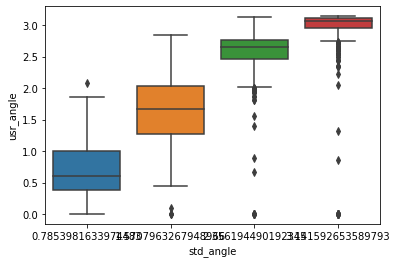

                  sum_sq      df           F         PR(>F)
C(std_angle)  473.125904     3.0  655.061748  1.014832e-248
Residual      278.311445  1156.0         NaN            NaN
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1             group2       meandiff p-adj lower  upper  reject
-------------------------------------------------------------------------
0.7853981633974483 1.5707963267948966   0.9553  -0.0 0.7784 1.1322   True
0.7853981633974483  2.356194490192345   1.8719  -0.0 1.7179 2.0259   True
0.7853981633974483  3.141592653589793    2.264  -0.0 2.1123 2.4156   True
1.5707963267948966  2.356194490192345   0.9166  -0.0 0.7934 1.0398   True
1.5707963267948966  3.141592653589793   1.3087  -0.0 1.1885 1.4289   True
 2.356194490192345  3.141592653589793   0.3921  -0.0 0.3092 0.4749   True
-------------------------------------------------------------------------


In [7]:
%matplotlib inline
df = pd.DataFrame({
    'std_angle': std_angles,
    'usr_angle': usr_angles
})
fig, axes = plt.subplots()
# sns.boxplot(x='std_angle', y='usr_angle', hue='order', data=df, ax=axes)
sns.boxplot(x='std_angle', y='usr_angle', data=df, ax=axes)
plt.show()
model = ols('usr_angle~C(std_angle)', data=df).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)
mc = MultiComparison(usr_angles, std_angles)
print(mc.tukeyhsd())

In [9]:
std_ang = np.pi / 4
l=[]
for id in np.where(np.array(std_angles) == std_ang)[0]:
    l.append(usr_angles[id])
inserted_len = len(l)
usr_angles1=usr_angles
std_angles1=std_angles
for i in range(inserted_len):
    usr_angles1.append(0)
    std_angles1.append(0)
mc = MultiComparison(usr_angles, std_angles)
print(mc.tukeyhsd())

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1             group2       meandiff p-adj lower  upper  reject
-------------------------------------------------------------------------
               0.0 0.7853981633974483    0.669   0.0 0.4639  0.874   True
               0.0 1.5707963267948966   1.6242   0.0 1.4425  1.806   True
               0.0  2.356194490192345   2.5409   0.0 2.3827 2.6991   True
               0.0  3.141592653589793   2.9329   0.0 2.7772 3.0887   True
0.7853981633974483 1.5707963267948966   0.9553   0.0 0.7735  1.137   True
0.7853981633974483  2.356194490192345   1.8719   0.0 1.7137 2.0301   True
0.7853981633974483  3.141592653589793    2.264   0.0 2.1082 2.4197   True
1.5707963267948966  2.356194490192345   0.9166   0.0 0.7901 1.0432   True
1.5707963267948966  3.141592653589793   1.3087   0.0 1.1852 1.4321   True
 2.356194490192345  3.141592653589793   0.3921   0.0  0.307 0.4771   True
--------------------------------------

In [5]:
from Plot import *


def angleDist(ang1, ang2):
    return 1 - (np.dot(ang1, ang2) / np.linalg.norm(ang1) /
                np.linalg.norm(ang2))
pressure_dict = [[[[] for ___ in range(8)] for _ in range(5)]
                    for __ in range(5)]

for dir in os.listdir(BASE_DIR):
    if not 'letter_' in dir or not os.path.isdir(
            os.path.join(BASE_DIR, dir)):
        continue
    for t_l_i, t_l in enumerate(LETTER):
        for rep in range(5):
            try:
                path = np.load(
                    os.path.join(BASE_DIR, dir, "%s_%d.npy" % (t_l, rep)))

                x, y, d = getAveragePath(path, align_to_first=False)
                corners = getCorners(path)
                directions_index, redundant_8directions, weights = get8Directions(
                    path)
                identified_directions_index = []

                path_directions = [
                    np.array([
                        np.cos(EIGHT_DIRECTIONS[i]),
                        np.sin(EIGHT_DIRECTIONS[i])
                    ]) for i in redundant_8directions
                ]
                std_directions = [
                    np.array([
                        np.cos(EIGHT_DIRECTIONS[i]),
                        np.sin(EIGHT_DIRECTIONS[i])
                    ]) for i in DIRECTION_PATTERN8[t_l]
                ]
                paths = dtw_ndim.warping_path(path_directions,
                                                std_directions)
                idx = 0
                while idx < len(paths):
                    match_list = []
                    current_std_idx = paths[idx][1]
                    while idx < len(
                            paths) and paths[idx][1] == current_std_idx:
                        match_list.append(paths[idx][0])
                        idx += 1
                    identified_directions_index.append(
                        directions_index[match_list[np.argmin([
                            angleDist(path_directions[m_l],
                                        std_directions[current_std_idx])
                            for m_l in match_list
                        ])]])

                # plt.axis("scaled")
                # plt.xlim(10, 17)
                # plt.ylim(15, 25)
                for ix, (iu, iv) in enumerate(identified_directions_index):
                    pressure_list = d[iu:iv]
                    pressure_dict[len(std_directions) - 1][ix][
                        DIRECTION_PATTERN8[t_l][ix]].append(pressure_list)
            except Exception as e:
                print(str(e))

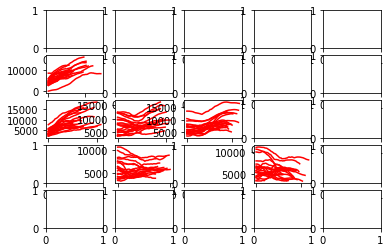

In [10]:
fig, axes = plt.subplots(5, 5)
for total_stroke_num in range(5):
    for stroke_idx in range(5):
        for stroke_dir in range(8):
            pressure_list = pressure_dict[total_stroke_num][stroke_idx][
                stroke_dir]
            if len(pressure_list) <= 0:
                continue
            for p_l in pressure_list:
                axes[total_stroke_num][stroke_idx].plot(
                    list(range(len(p_l))),
                    p_l,
                    c=COLORS[stroke_dir])
plt.show()

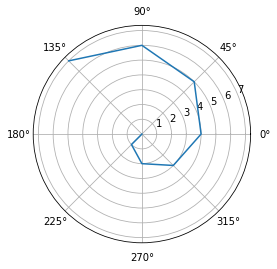

In [290]:
%matplotlib inline
angles = [(i - 4) * np.pi / 4 for i in range(8)]
data = [0,1,2,3,4,5,6,7]
fig = plt.figure()
ax = plt.subplot(111, polar=True)
ax.set_theta_zero_location('E')
ax.plot(angles,data)
plt.show()

In [1]:
from Plot import *
path_dict = [{} for _ in range(5)]
for dir in os.listdir(BASE_DIR):
    if dir == 'test':
        continue
    for k, num_d in enumerate([4,6,8,10,12]):
        paths = [[] for _ in range(int(num_d))]
        for i, c in enumerate(DIRECTIONS_MAP[str(num_d)]):
            for j in range(5):
                path = np.load(
                    os.path.join(BASE_DIR, dir, '0',str(num_d),
                                    str(i) + '_{}.npy'.format(j)))
                x, y, d = getAveragePath(path)
                paths[i].append((x, y, d))
        path_dict[k][dir]=paths

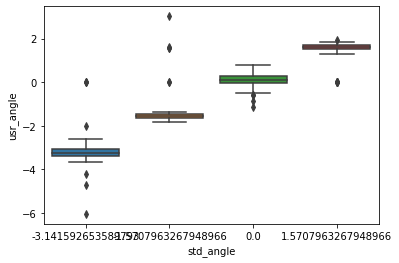

                  sum_sq     df           F         PR(>F)
C(std_angle)  881.602371    3.0  687.881425  8.713332e-133
Residual      126.025935  295.0         NaN            NaN
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2       meandiff p-adj lower  upper  reject
---------------------------------------------------------------------------
 -3.141592653589793 -1.5707963267948966   1.8127  -0.0  1.537 2.0885   True
 -3.141592653589793                 0.0   3.2475  -0.0 2.9717 3.5233   True
 -3.141592653589793  1.5707963267948966   4.6359  -0.0 4.3592 4.9126   True
-1.5707963267948966                 0.0   1.4348  -0.0  1.159 1.7105   True
-1.5707963267948966  1.5707963267948966   2.8232  -0.0 2.5465 3.0999   True
                0.0  1.5707963267948966   1.3884  -0.0 1.1117 1.6651   True
---------------------------------------------------------------------------


In [20]:
usr_angles = []
std_angles = []
num_d = 4
for name, paths in path_dict[[4,6,8,10,12].index(num_d)].items():
    for i, c in enumerate(DIRECTIONS_MAP[str(num_d)]):
        for j in range(5):
            x, y, d = paths[i][j]
            if len(d) <= 0:
                continue
            x = gaussian_filter1d(x, sigma=5)
            y = gaussian_filter1d(y, sigma=5)
            corners = getCorners(x, y, d)
            start, end = getLongestDirection(x, y, d, corners)
            if end < 0:
                continue
            angle = np.arctan2(y[end] - y[start], x[end] - x[start])
            # if angle > (DIRECTIONS_MAP[args.direction][-1] + np.pi) / 2:
            if c == -np.pi and angle > 0:
                angle -= 2 * np.pi
            usr_angles.append(angle)
            std_angles.append(c)
df = pd.DataFrame({'std_angle': std_angles, 'usr_angle': usr_angles})
fig, axes = plt.subplots()
sns.boxplot(x='std_angle', y='usr_angle', data=df, ax=axes)
plt.show()
df = pd.DataFrame({'std_angle': std_angles, 'usr_angle': usr_angles})
model = ols('usr_angle~C(std_angle)', data=df).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)
mc = MultiComparison(usr_angles, std_angles)
print(mc.tukeyhsd())

0.7425035941144074

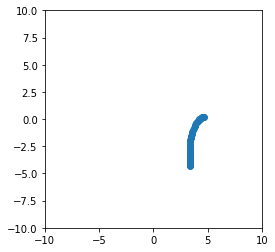

In [19]:
%matplotlib inline
from Plot import *
path = np.load('study2/pilot4/v_3.npy')
x, y, d = getAveragePath(path)
x = gaussian_filter1d(x, sigma=8)
y = gaussian_filter1d(y, sigma=8)
plt.axis('scaled')
plt.xlim(-10,10)
plt.ylim(-10,10)
lo, hi = 47, 85
plt.scatter(x[lo:hi],y[lo:hi])
slope, intercept, r_value, p_value, std_err = stats.linregress(x[lo:hi],y[lo:hi])
r_value**2

In [1]:
import numpy as np

from Plot import valid_study2_data, STUDY2_DIR

error_data_filenames = np.load(os.path.join(STUDY2_DIR, 'error.npy'))
zero_data_filenames = np.load(os.path.join(STUDY2_DIR, 'zero.npy'))
overlap_data_filenames = np.load(os.path.join(STUDY2_DIR, 'overlap.npy'))
for pers in valid_study2_data:
    error_n = 0
    zero_n = 0
    overlap_n = 0
    for e in error_data_filenames:
        if pers in e:
            error_n+=1
    for t in zero_data_filenames:
        if pers in t:
            zero_n+=1
    for o in overlap_data_filenames:
        if pers in o:
            overlap_n+=1
    print(pers, error_n,zero_n,overlap_n)

cly 8 0 8
djy 11 2 1
fjl 86 0 25
gyf 1 0 13
jyw 9 1 16
ljy 11 0 38
lly 7 0 2
lm 10 0 5
mhb 5 0 16
stp 31 1 3
wsw 13 0 4
ykh 10 0 61
ytj 3 0 3
yxy 17 0 7
yyq 31 0 22
zxw 29 0 4
zyw 12 0 15


In [5]:
import numpy as np
from Plot import *
%matplotlib qt5
pressure = np.load('study2/se_pressure.npy')
speed = np.load('study2/se_speed.npy')
label1 = np.load('study2/se_label1.npy')
label2 = np.load('study2/se_label2.npy')
fig, axes = plt.subplots(1, 2)
df = pd.DataFrame({
    'pressure': pressure,
    'label1': label1,
})
sns.boxplot(x='label1', y='pressure', data=df, ax=axes[0])
df = pd.DataFrame({
    'speed': speed,
    'label2': label2,
})
sns.boxplot(x='label2', y='speed', data=df, ax=axes[1])
plt.show()

In [2]:
import numpy as np
from Plot import *
%matplotlib qt5
pressure = np.load('study2/se_pressure.npy')
speed = np.load('study2/se_speed.npy')
label1 = np.load('study2/se_label1.npy')
label2 = np.load('study2/se_label2.npy')
pressure_nan = np.isnan(pressure)
speed_nan = np.isnan(speed)
stroke_avg = []
stroke_max = []
start_max = []
end_max = []
fig, axes = plt.subplots(1, 2)
for i in range(0,len(pressure),4):
    if not pressure_nan[i]:
        axes[0].scatter([i],[pressure[i]],c='red',alpha=0.01)
    if not pressure_nan[i+1]:
        axes[0].scatter([i],[pressure[i+1]],c='blue',alpha=0.01)
    if not pressure_nan[i+2]:
        axes[0].scatter([i],[pressure[i+2]],c='green',alpha=0.01)
    if not pressure_nan[i+3]:
        axes[0].scatter([i],[pressure[i+3]],c='purple',alpha=0.01)
    if not speed_nan[i]:
        axes[1].scatter([i],[speed[i]],c='red',alpha=0.01)
    if not speed_nan[i+1]:
        axes[1].scatter([i],[speed[i+1]],c='blue',alpha=0.01)
    if not speed_nan[i+2]:
        axes[1].scatter([i],[speed[i+2]],c='green',alpha=0.01)
    if not speed_nan[i+3]:
        axes[1].scatter([i],[speed[i+3]],c='purple',alpha=0.01)

In [11]:
print(np.average(pressure[np.arange(
    0, len(pressure),
    4)][np.where(~np.isnan(pressure[np.arange(0, len(pressure), 4)]))]))
print(np.average(pressure[np.arange(
    1, len(pressure),
    4)][np.where(~np.isnan(pressure[np.arange(1, len(pressure), 4)]))]))
print(np.average(pressure[np.arange(
    2, len(pressure),
    4)][np.where(~np.isnan(pressure[np.arange(2, len(pressure), 4)]))]))
print(np.average(pressure[np.arange(
    3, len(pressure),
    4)][np.where(~np.isnan(pressure[np.arange(3, len(pressure), 4)]))]))


87.09359782613936
488.4760954964612
161.07815696722417
363.2327818907754


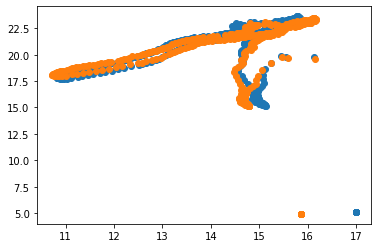

In [10]:
from constants import *

person = 'cly'
t_l = 'a'
rep = 0

offset_dict = json.load(open('offset.json', 'r'))
offset = offset_dict['cly']
path_name = os.path.join(STUDY2_DIR, person + '1',
                            t_l + '_' + str(rep) + '.npy')
personal = False
if not os.path.exists(path_name):
    path_name = os.path.join(STUDY2_DIR, person,
                                t_l + '_' + str(rep) + '.npy')
    personal = True
path = np.load(path_name)

points_x = []
points_y = []
depths = []
threshold = 0

for frame in path:
    sum_force = 0
    x_average = 0
    y_average = 0
    for y_coordinate in range(len(frame)):
        for x_coordinate in range(len(frame[y_coordinate])):
            sum_force += frame[y_coordinate][x_coordinate]
    if sum_force > threshold:
        for y_coordinate in range(len(frame)):
            for x_coordinate in range(len(
                    frame[y_coordinate])):
                rate = frame[y_coordinate][
                    x_coordinate] / sum_force
                x_average += rate * x_coordinate
                y_average += rate * y_coordinate
        points_x.append(x_average)
        points_y.append(35 - y_average)
        depths.append(sum_force)
plt.scatter(points_x,points_y)
cx = np.average(points_x)
cy = np.average(points_y)
if personal:
    x = []
    y = []
    for ii in range(len(points_x)):
        xx = points_x[ii]
        yy = points_y[ii]
        r = np.linalg.norm((xx - cx, yy - cy))
        theta = np.arctan2(yy - cy, xx - cx)
        theta = theta + offset
        x.append(cx + r * np.cos(theta))
        y.append(cy + r * np.sin(theta))
    plt.scatter(x, y)

In [8]:
from constants import *
person = 'ysq'

meta = json.load(open(os.path.join(STUDY3_DIR, person, 'meta.json')))
seconds = 0
for filename in os.listdir(os.path.join(STUDY3_DIR, person, '5')):

    path = np.load(os.path.join(STUDY3_DIR, person, '5', filename))
    frames = len(path[0])
    seconds += frames / 300
print((meta['5']['total_letters'] - 1) * 12 / seconds)

seconds = 0
for st in meta['5']['starts_and_ends']:
    seconds += st['end']-st['start']
print((meta['5']['total_letters'] - 1) * 12 / seconds)


13.740458015267171
3.4815913095431443
